In [3]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Загрузим данные - в нашем датасете уже фигурировали dummy-переменные,
# но часть из них (в том числе и выбранные нами в качестве регрессоров has_5g и has_nfc)
# имели значения True/False,
# мы с помощью Excel заменили их на 1/0 соответсвенно, также нами были удалены те перменные,
# которые не будут использоваться при построении модели и в дальнейшем анализе
# а еще мы предварительно очистили датасет от пропущенных значений:

cleaned_data = pd.read_excel('cleaned_smartphones.xlsx')

display(cleaned_data.head(10))

print(f'Размер очищенного от пропусков датасета: {cleaned_data.shape}')

,model,price,has_5g,has_nfc,num_cores,processor_speed,battery_capacity,ram_capacity,internal_memory,screen_size,refresh_rate,num_rear_cameras,num_front_cameras,extended_memory_available
0,OnePlus 11 5G,54999,1,1,8,3.20,5000,12,256,6.70,120,3,1,0
1,OnePlus Nord CE 2 Lite 5G,19989,1,0,8,2.20,5000,6,128,6.59,120,3,1,1
2,Samsung Galaxy A14 5G,16499,1,0,8,2.40,5000,4,64,6.60,90,3,1,1
3,Motorola Moto G62 5G,14999,1,0,8,2.20,5000,6,128,6.55,120,3,1,1
4,Realme 10 Pro Plus,24999,1,0,8,2.60,5000,6,128,6.70,120,3,1,0
5,Samsung Galaxy F23 5G (6GB RAM + 128GB),16999,1,1,8,2.20,5000,6,128,6.60,120,3,1,1
6,Apple iPhone 14,65999,1,1,6,3.22,3279,6,128,6.10,60,2,1,0
7,Xiaomi Redmi Note 12 Pro Plus,29999,1,0,8,2.60,4980,8,256,6.67,120,3,1,0
8,Nothing Phone 1,26749,1,1,8,2.50,4500,8,128,6.55,120,2,1,0
9,OnePlus Nord 2T 5G,28999,1,1,8,3.00,4500,8,128,6.43,90,3,1,0


Размер очищенного от пропусков датасета: (924, 14)


,price,num_cores,processor_speed,battery_capacity,ram_capacity,internal_memory,screen_size,refresh_rate,num_rear_cameras,num_front_cameras
count,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000
mean,37251.536396,7.803030,2.418907,4828.524892,6.567100,137.601732,6.545812,92.545455,2.822511,1.031385
std,46004.773559,0.811718,0.459338,1018.990631,2.750522,97.250776,0.330352,28.830981,0.773961,0.174451
min,4303.770000,4.000000,1.200000,1821.000000,1.000000,8.000000,3.540000,60.000000,1.000000,1.000000
25%,15988.770000,8.000000,2.050000,4500.000000,4.000000,64.000000,6.500000,60.000000,2.000000,1.000000
50%,24372.450000,8.000000,2.300000,5000.000000,6.000000,128.000000,6.580000,90.000000,3.000000,1.000000
75%,40588.770000,8.000000,2.840000,5000.000000,8.000000,128.000000,6.670000,120.000000,3.000000,1.000000
max,799500.000000,8.000000,3.220000,22000.000000,18.000000,1024.000000,8.030000,240.000000,4.000000,2.000000


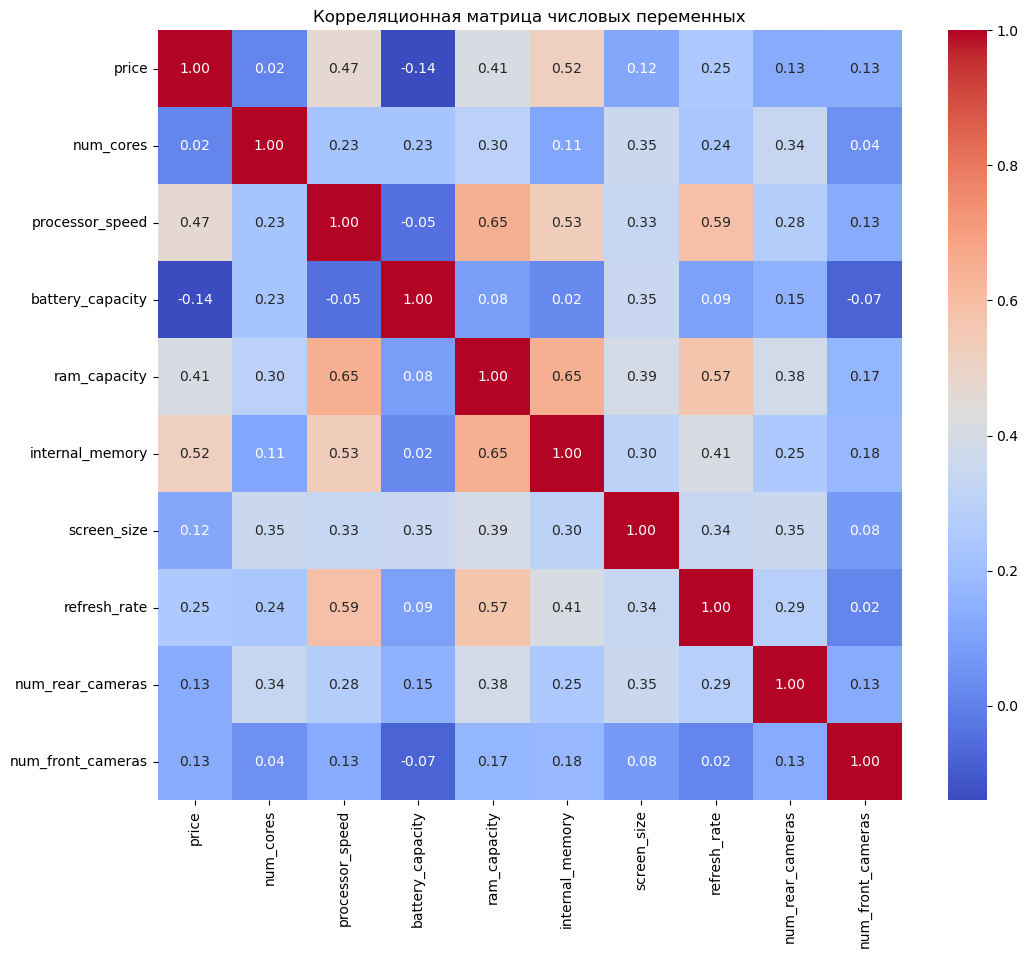

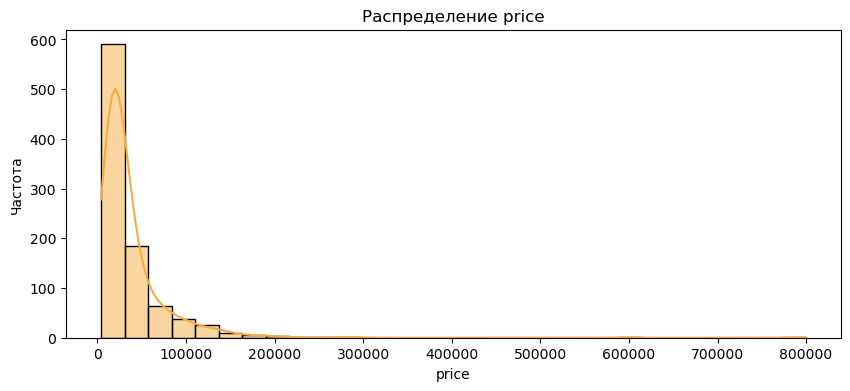

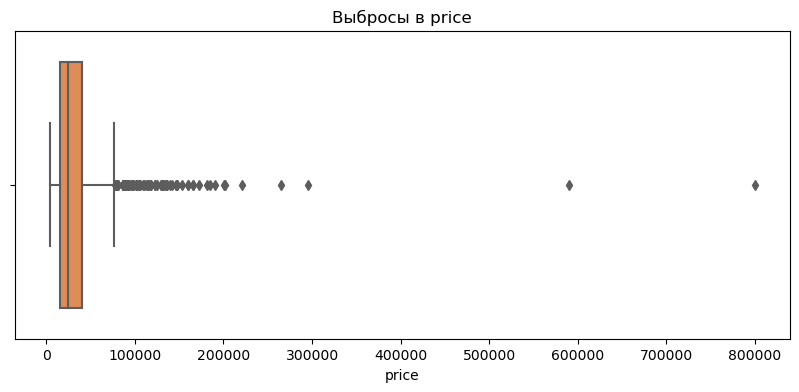

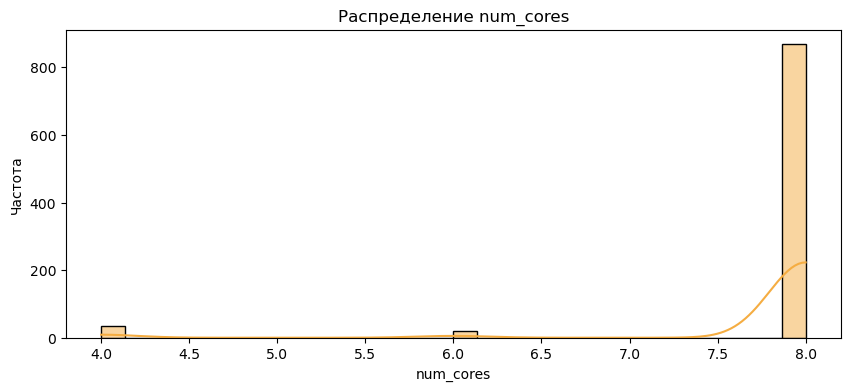

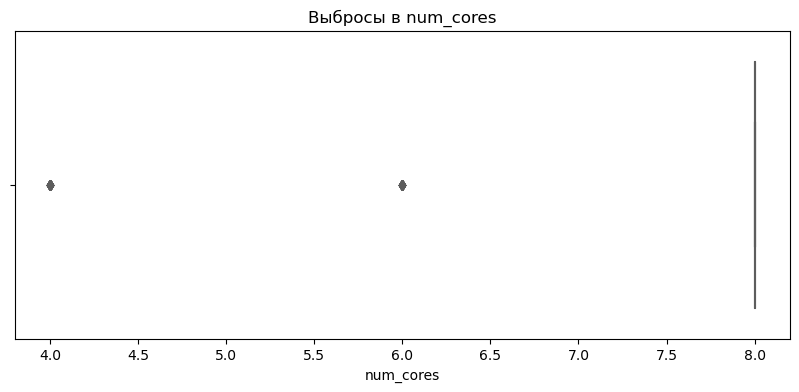

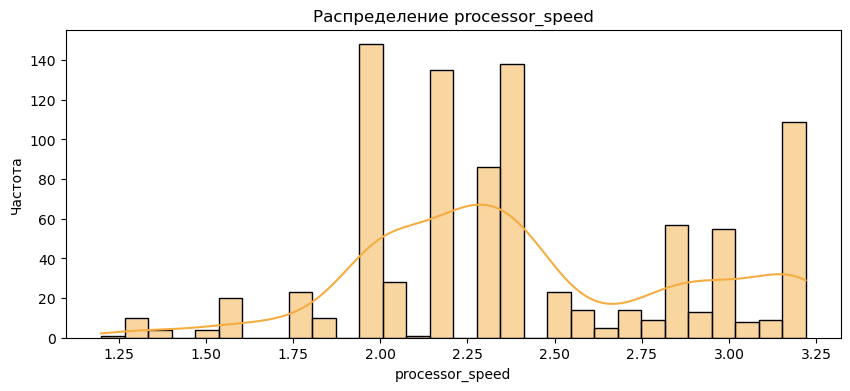

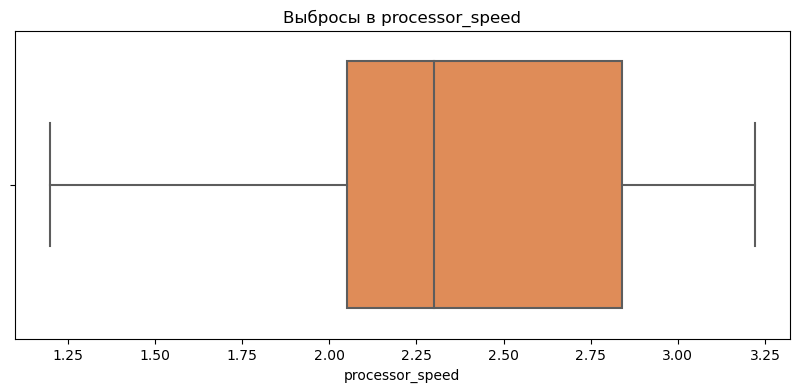

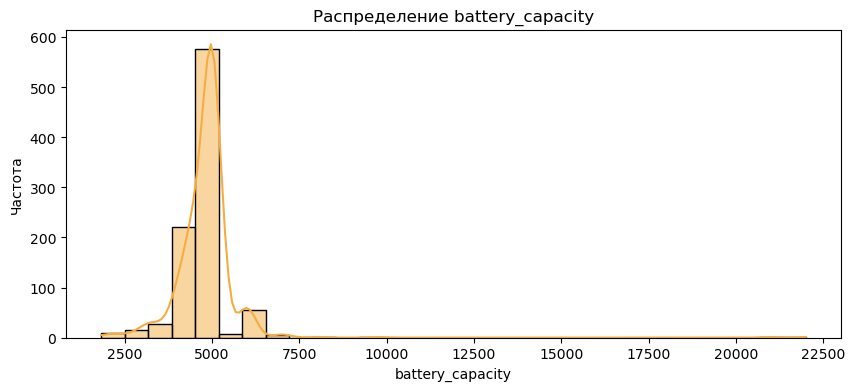

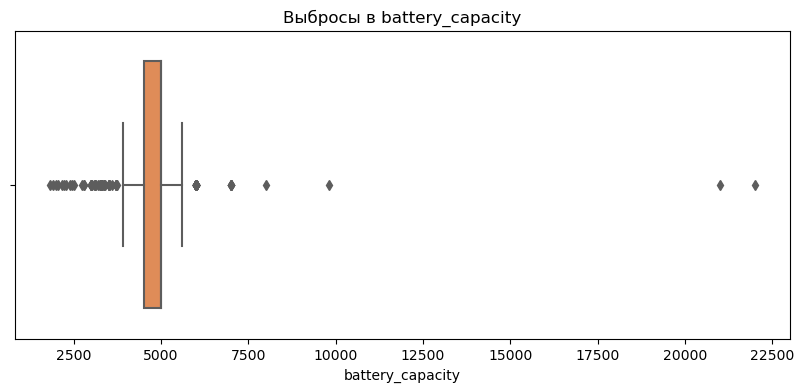

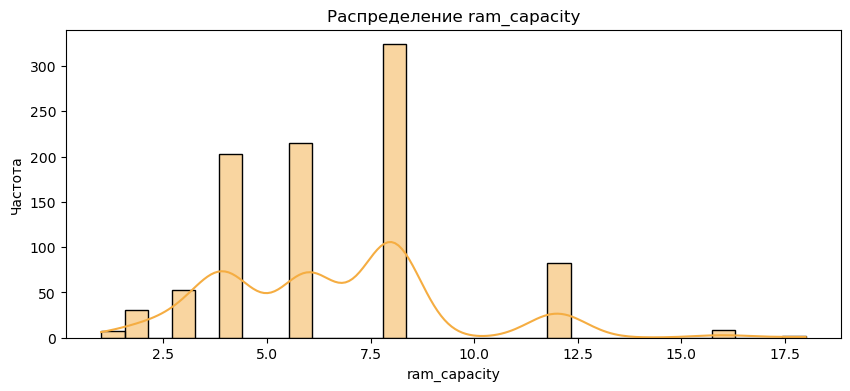

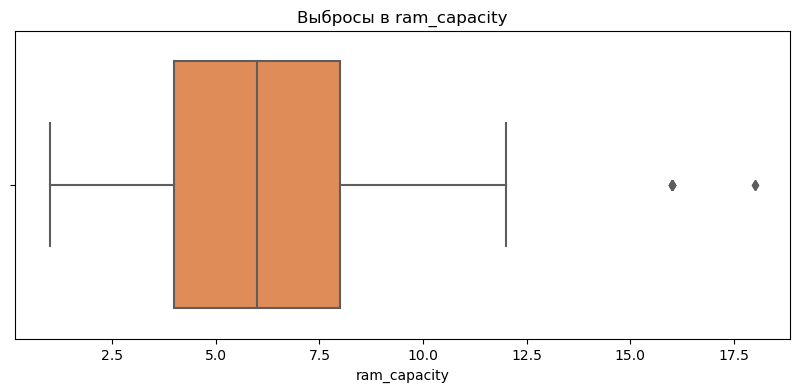

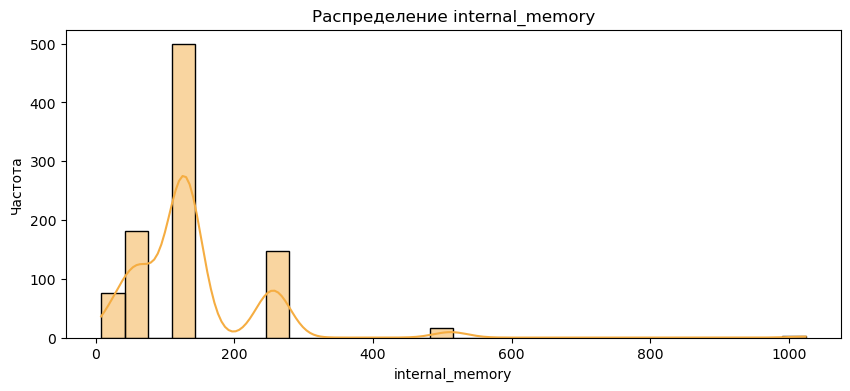

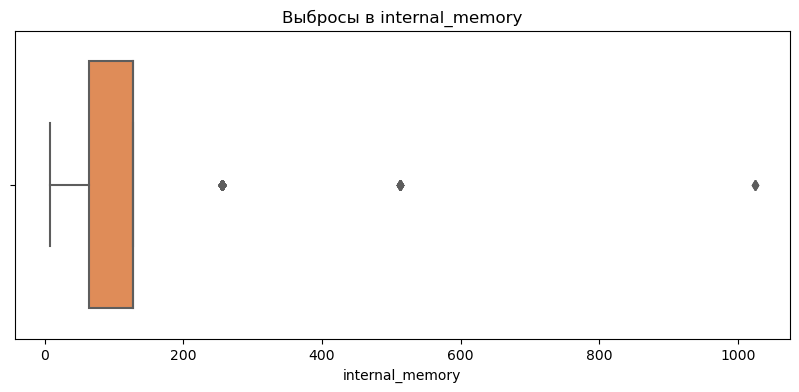

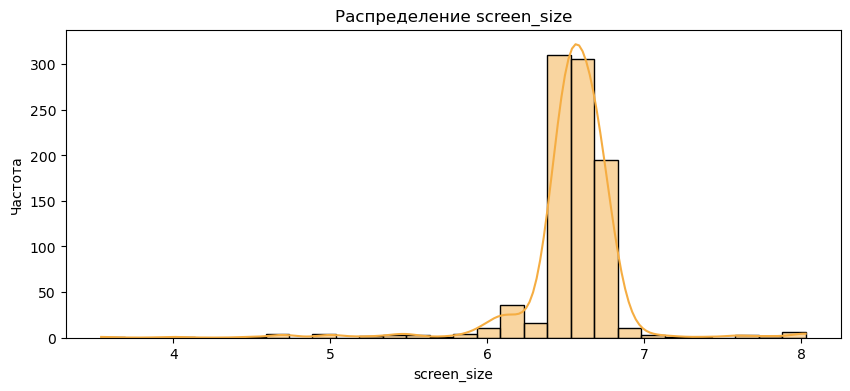

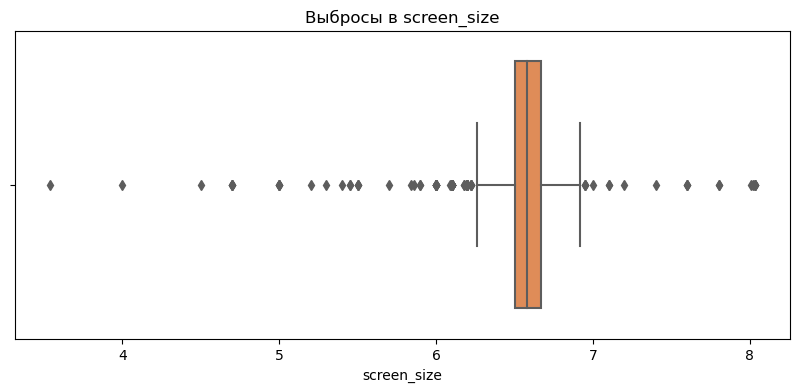

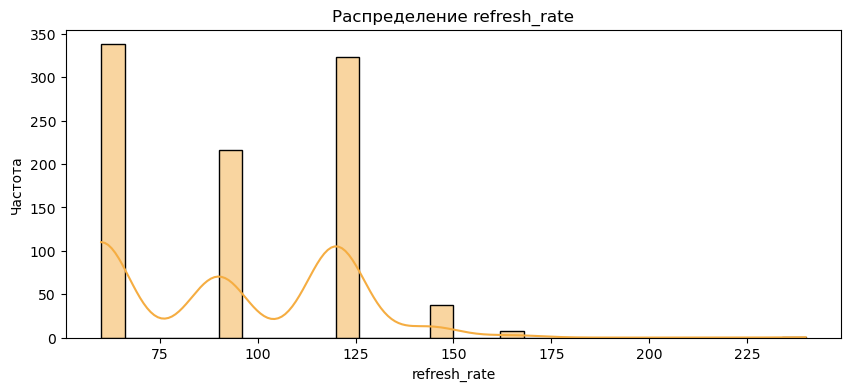

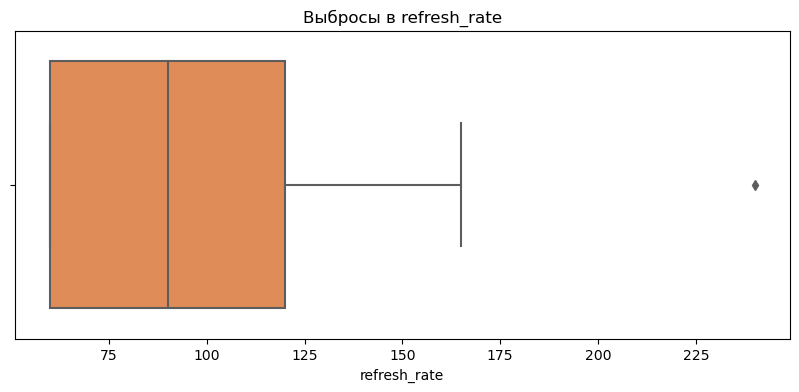

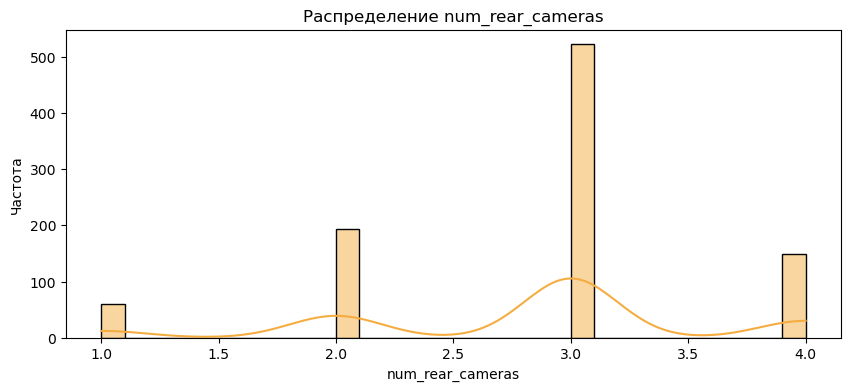

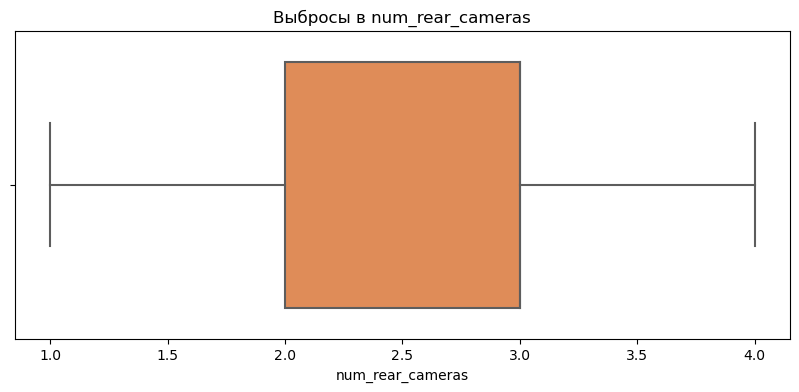

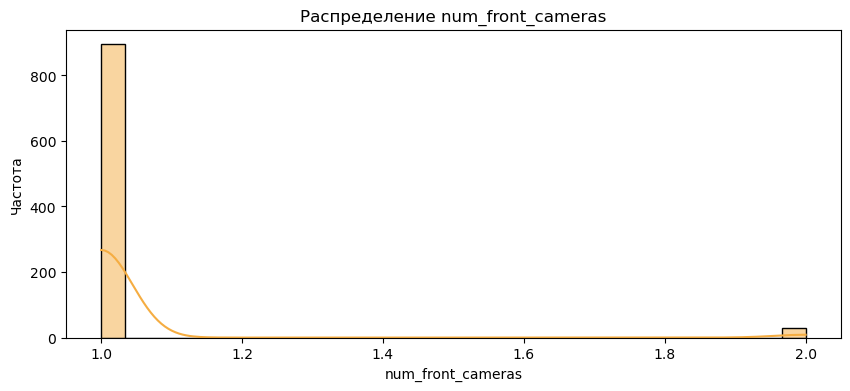

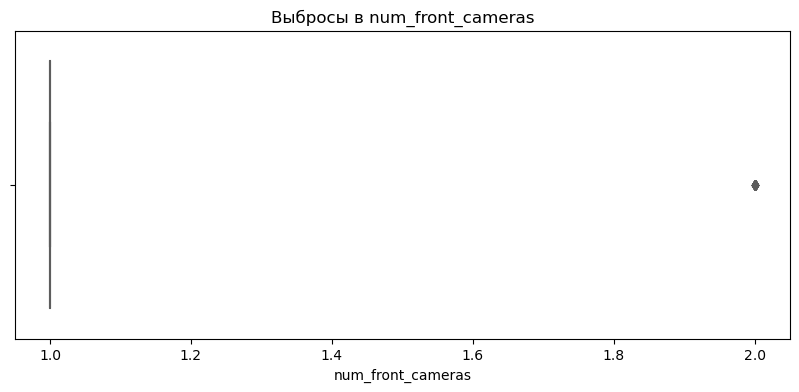

In [5]:
# Проведем EDA, для большей наглядности временно исключим из датасета dummy-переменные
# (has_5g, has_nfc, extended_memory_available) -
# нам нет смысла смотреть на их описательные статистики, распределение и т. д.:

df = cleaned_data.copy()

columns_to_exclude = ['has_5g', 'has_nfc', 'extended_memory_available']
df_filtered = df.drop(columns=columns_to_exclude)

# В исходном датасете цены были в индийских рупиях, переведем их в рубли для большего удобства (курс на 12.12):
df_filtered['price'] = df_filtered['price'] * 1.23

descriptive_stats_filtered = df_filtered.describe()

correlation_matrix_filtered = df_filtered.corr(numeric_only=True)

styled_descriptive_stats_filtered = descriptive_stats_filtered.style.background_gradient(cmap="coolwarm").set_caption("Filtered Descriptive Statistics")
display(descriptive_stats_filtered)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_filtered, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица числовых переменных")
plt.show()

numeric_columns_filtered = df_filtered.select_dtypes(include=['number']).columns

for column in numeric_columns_filtered:
    plt.figure(figsize=(10, 4))
    sns.histplot(df_filtered[column].dropna(), kde=True, bins=30, color="#f5ad42")
    plt.title(f"Распределение {column}")
    plt.xlabel(column)
    plt.ylabel("Частота")
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df_filtered[column], color="#f58742")
    plt.title(f"Выбросы в {column}")
    plt.xlabel(column)
    plt.show()

In [6]:
# Теперь займемся построением моделей регрессии, начнем с самого простого варианта -
# обычной линейной регрессии с константой:

df = cleaned_data.copy()

X = df[['num_cores',
        'processor_speed',
        'ram_capacity',
        'battery_capacity',
        'internal_memory',
        'screen_size',
        'refresh_rate',
        'num_rear_cameras',
        'num_front_cameras',
        'has_5g',
        'has_nfc',
        'extended_memory_available']]

y = df['price']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

coefficients = model.params

equation = "price = "
terms = [f"{coefficients['const']:.4f}"]
for feature in X.columns[1:]:
    terms.append(f"{coefficients[feature]:+.4f} * {feature}")

equation += " ".join(terms)

print()
print()
print("Уравнение регрессии:")
print()
print(equation)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     46.68
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           2.11e-86
Time:                        19:20:22   Log-Likelihood:                -10818.
No. Observations:                 924   AIC:                         2.166e+04
Df Residuals:                     911   BIC:                         2.173e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [7]:
# Результаты нас расстроили, R^2=0.38 всегда грустно, так что попробуем что-нибудь поинтереснее:

cleaned_data_with_brand = pd.read_excel('cleaned_smartphones_brand.xlsx')

df = cleaned_data_with_brand.copy()

df = df[df['price'] > 0].copy()  
df['log_price'] = np.log(df['price'])

df = df[df['processor_speed'] > 0].copy()
df['log_processor_speed'] = np.log(df['processor_speed'])

df = df[df['internal_memory'] > 0].copy()

df['internal_memory_sq'] = df['internal_memory']**2

df['refresh_rate_sq'] = df['refresh_rate']**2

formula = """
log_price ~ num_cores + log_processor_speed + ram_capacity + battery_capacity
+ internal_memory + internal_memory_sq + screen_size + refresh_rate + refresh_rate_sq
+ num_rear_cameras + num_front_cameras + has_5g + has_nfc + extended_memory_available
+ C(brand)
"""

model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

coefficients = model.params

equation = "log_price = "
terms = [f"{coefficients['Intercept']:.4f}"]
for feature, coef in coefficients.items():
    if feature != "Intercept":
        terms.append(f"{coef:+.4f} * {feature}")

equation += " ".join(terms)

print()
print()
print("Уравнение регрессии:")
print()
print(equation)

# Вот это уже другое дело!

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     103.8
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:20:23   Log-Likelihood:                -66.330
No. Observations:                 924   AIC:                             256.7
Df Residuals:                     862   BIC:                             556.0
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [9]:
# Проверим гипотезу о равенстве коэффициентов для группы китайских брендов
# Для этого сформируем строку для f_test, указав необходимые линейные ограничения:

f_test_hyp = """
C(brand)[T.Huawei] = C(brand)[T.Xiaomi],
C(brand)[T.Xiaomi] = C(brand)[T.OPPO],
C(brand)[T.OPPO] = C(brand)[T.OnePlus]
"""

f_test_result = model.f_test(f_test_hyp)


print(f'Результат проведения F-теста:')
print()
print(f_test_result)

Результат проведения F-теста:

<F test: F=9.963133478484044, p=1.8454249900904023e-06, df_denom=862, df_num=3>
